In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


     |████████████████████████████████| 123 kB 20.6 MB/s 


     |███████████████████████▉        | 1.2 MB 34.3 MB/s eta 0:00:01

     |████████████████████████████████| 1.6 MB 34.3 MB/s 


     |████████████████████████████████| 245 kB 29.7 MB/s 


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


     |████████████████████████████████| 292 kB 19.8 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


     |██▏                             | 256 kB 19.6 MB/s eta 0:00:01

     |████████████▏                   | 1.5 MB 19.6 MB/s eta 0:00:01

     |██████████████████████▎         | 2.7 MB 19.6 MB/s eta 0:00:01

     |████████████████████████████████| 3.8 MB 19.6 MB/s 


     |██▋                             | 542 kB 17.8 MB/s eta 0:00:01

     |████████▌                       | 1.7 MB 17.8 MB/s eta 0:00:01

     |██████████████▎                 | 2.9 MB 17.8 MB/s eta 0:00:01

     |███████████████████▋            | 4.0 MB 17.8 MB/s eta 0:00:01

     |██████████████████████████▎     | 5.4 MB 17.8 MB/s eta 0:00:01

     |████████████████████████████████| 6.5 MB 17.8 MB/s 


     |████████████████████████████████| 67 kB 41.1 MB/s 


In [ ]:
from tqdm import tqdm

In [ ]:
import sys
!{sys.executable} -m pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import (ElectraForSequenceClassification, ElectraTokenizerFast)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
%cd drive/MyDrive/twitter_training/

In [ ]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2


In [ ]:
df['label'].value_counts()

In [ ]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,data_type,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,train,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,train,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,train,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,train,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,val,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

In [ ]:
df.head()

## Balance training data

In [ ]:
df[df.data_type=='train']['label'].value_counts()

In [ ]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [ ]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "google/electra-small-discriminator"

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-small-discriminator", do_lower_case=True)  

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

### Find max length for tokenizer

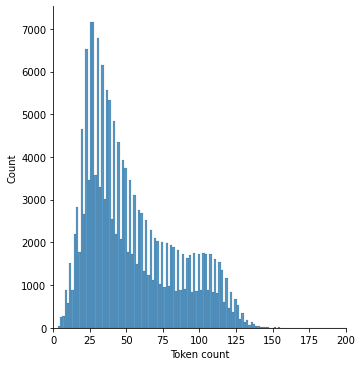

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [ ]:
max_length = 170

### Encode messages

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(dataset_train), len(dataset_val)

(116334, 26197)

# Model "google/electra-small-discriminator"

In [ ]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels = 3)

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsCleaned-pnn/finetuned_ELECTRA_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:02<?, ?it/s, training_loss=0.368]

Epoch 1:   0%|          | 1/3636 [00:02<2:09:34,  2.14s/it, training_loss=0.368]

Epoch 1:   0%|          | 1/3636 [00:02<2:09:34,  2.14s/it, training_loss=0.369]

Epoch 1:   0%|          | 2/3636 [00:02<1:06:28,  1.10s/it, training_loss=0.369]

Epoch 1:   0%|          | 2/3636 [00:02<1:06:28,  1.10s/it, training_loss=0.363]

Epoch 1:   0%|          | 3/3636 [00:02<46:17,  1.31it/s, training_loss=0.363]  

Epoch 1:   0%|          | 3/3636 [00:03<46:17,  1.31it/s, training_loss=0.368]

Epoch 1:   0%|          | 4/3636 [00:03<36:52,  1.64it/s, training_loss=0.368]

Epoch 1:   0%|          | 4/3636 [00:03<36:52,  1.64it/s, training_loss=0.366]

Epoch 1:   0%|          | 5/3636 [00:03<31:55,  1.90it/s, training_loss=0.366]

Epoch 1:   0%|          | 5/3636 [00:04<31:55,  1.90it/s, training_loss=0.368]

Epoch 1:   0%|          | 6/3636 [00:04<28:43,  2.11it/s, training_loss=0.368]

Epoch 1:   0%|          | 6/3636 [00:04<28:43,  2.11it/s, training_loss=0.367]

Epoch 1:   0%|          | 7/3636 [00:04<26:39,  2.27it/s, training_loss=0.367]

Epoch 1:   0%|          | 7/3636 [00:04<26:39,  2.27it/s, training_loss=0.364]

Epoch 1:   0%|          | 8/3636 [00:04<25:15,  2.39it/s, training_loss=0.364]

Epoch 1:   0%|          | 8/3636 [00:05<25:15,  2.39it/s, training_loss=0.366]

Epoch 1:   0%|          | 9/3636 [00:05<24:26,  2.47it/s, training_loss=0.366]

Epoch 1:   0%|          | 9/3636 [00:05<24:26,  2.47it/s, training_loss=0.365]

Epoch 1:   0%|          | 10/3636 [00:05<23:49,  2.54it/s, training_loss=0.365]

Epoch 1:   0%|          | 10/3636 [00:05<23:49,  2.54it/s, training_loss=0.367]

Epoch 1:   0%|          | 11/3636 [00:05<23:21,  2.59it/s, training_loss=0.367]

Epoch 1:   0%|          | 11/3636 [00:06<23:21,  2.59it/s, training_loss=0.368]

Epoch 1:   0%|          | 12/3636 [00:06<23:02,  2.62it/s, training_loss=0.368]

Epoch 1:   0%|          | 12/3636 [00:06<23:02,  2.62it/s, training_loss=0.367]

Epoch 1:   0%|          | 13/3636 [00:06<22:50,  2.64it/s, training_loss=0.367]

Epoch 1:   0%|          | 13/3636 [00:06<22:50,  2.64it/s, training_loss=0.365]

Epoch 1:   0%|          | 14/3636 [00:06<22:46,  2.65it/s, training_loss=0.365]

Epoch 1:   0%|          | 14/3636 [00:07<22:46,  2.65it/s, training_loss=0.366]

Epoch 1:   0%|          | 15/3636 [00:07<22:36,  2.67it/s, training_loss=0.366]

Epoch 1:   0%|          | 15/3636 [00:07<22:36,  2.67it/s, training_loss=0.367]

Epoch 1:   0%|          | 16/3636 [00:07<22:28,  2.68it/s, training_loss=0.367]

Epoch 1:   0%|          | 16/3636 [00:08<22:28,  2.68it/s, training_loss=0.368]

Epoch 1:   0%|          | 17/3636 [00:08<22:22,  2.70it/s, training_loss=0.368]

Epoch 1:   0%|          | 17/3636 [00:08<22:22,  2.70it/s, training_loss=0.365]

Epoch 1:   0%|          | 18/3636 [00:08<22:19,  2.70it/s, training_loss=0.365]

Epoch 1:   0%|          | 18/3636 [00:08<22:19,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 19/3636 [00:08<22:18,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 19/3636 [00:09<22:18,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 20/3636 [00:09<22:19,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 20/3636 [00:09<22:19,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 21/3636 [00:09<22:16,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|          | 21/3636 [00:09<22:16,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 22/3636 [00:09<22:13,  2.71it/s, training_loss=0.366]

Epoch 1:   1%|          | 22/3636 [00:10<22:13,  2.71it/s, training_loss=0.365]

Epoch 1:   1%|          | 23/3636 [00:10<22:10,  2.72it/s, training_loss=0.365]

Epoch 1:   1%|          | 23/3636 [00:10<22:10,  2.72it/s, training_loss=0.367]

Epoch 1:   1%|          | 24/3636 [00:10<22:07,  2.72it/s, training_loss=0.367]

Epoch 1:   1%|          | 24/3636 [00:11<22:07,  2.72it/s, training_loss=0.365]

Epoch 1:   1%|          | 25/3636 [00:11<22:03,  2.73it/s, training_loss=0.365]

Epoch 1:   1%|          | 25/3636 [00:11<22:03,  2.73it/s, training_loss=0.369]

Epoch 1:   1%|          | 26/3636 [00:11<22:21,  2.69it/s, training_loss=0.369]

Epoch 1:   1%|          | 26/3636 [00:11<22:21,  2.69it/s, training_loss=0.368]

Epoch 1:   1%|          | 27/3636 [00:11<22:18,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|          | 27/3636 [00:12<22:18,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 28/3636 [00:12<22:27,  2.68it/s, training_loss=0.366]

Epoch 1:   1%|          | 28/3636 [00:12<22:27,  2.68it/s, training_loss=0.367]

Epoch 1:   1%|          | 29/3636 [00:12<22:17,  2.70it/s, training_loss=0.367]

Epoch 1:   1%|          | 29/3636 [00:12<22:17,  2.70it/s, training_loss=0.367]

Epoch 1:   1%|          | 30/3636 [00:12<22:11,  2.71it/s, training_loss=0.367]

Epoch 1:   1%|          | 30/3636 [00:13<22:11,  2.71it/s, training_loss=0.365]

Epoch 1:   1%|          | 31/3636 [00:13<22:23,  2.68it/s, training_loss=0.365]

Epoch 1:   1%|          | 31/3636 [00:13<22:23,  2.68it/s, training_loss=0.368]

Epoch 1:   1%|          | 32/3636 [00:13<22:15,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|          | 32/3636 [00:14<22:15,  2.70it/s, training_loss=0.362]

Epoch 1:   1%|          | 33/3636 [00:14<22:28,  2.67it/s, training_loss=0.362]

Epoch 1:   1%|          | 33/3636 [00:14<22:28,  2.67it/s, training_loss=0.365]

Epoch 1:   1%|          | 34/3636 [00:14<22:21,  2.68it/s, training_loss=0.365]

Epoch 1:   1%|          | 34/3636 [00:14<22:21,  2.68it/s, training_loss=0.369]

Epoch 1:   1%|          | 35/3636 [00:14<22:12,  2.70it/s, training_loss=0.369]

Epoch 1:   1%|          | 35/3636 [00:15<22:12,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 36/3636 [00:15<22:11,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 36/3636 [00:15<22:11,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|          | 37/3636 [00:15<22:07,  2.71it/s, training_loss=0.368]

Epoch 1:   1%|          | 37/3636 [00:15<22:07,  2.71it/s, training_loss=0.365]

Epoch 1:   1%|          | 38/3636 [00:15<22:02,  2.72it/s, training_loss=0.365]

Epoch 1:   1%|          | 38/3636 [00:16<22:02,  2.72it/s, training_loss=0.366]

Epoch 1:   1%|          | 39/3636 [00:16<22:00,  2.72it/s, training_loss=0.366]

Epoch 1:   1%|          | 39/3636 [00:16<22:00,  2.72it/s, training_loss=0.363]

Epoch 1:   1%|          | 40/3636 [00:16<21:57,  2.73it/s, training_loss=0.363]

Epoch 1:   1%|          | 40/3636 [00:16<21:57,  2.73it/s, training_loss=0.368]

Epoch 1:   1%|          | 41/3636 [00:16<22:02,  2.72it/s, training_loss=0.368]

Epoch 1:   1%|          | 41/3636 [00:17<22:02,  2.72it/s, training_loss=0.365]

Epoch 1:   1%|          | 42/3636 [00:17<22:22,  2.68it/s, training_loss=0.365]

Epoch 1:   1%|          | 42/3636 [00:17<22:22,  2.68it/s, training_loss=0.366]

Epoch 1:   1%|          | 43/3636 [00:17<22:15,  2.69it/s, training_loss=0.366]

Epoch 1:   1%|          | 43/3636 [00:18<22:15,  2.69it/s, training_loss=0.368]

Epoch 1:   1%|          | 44/3636 [00:18<22:10,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|          | 44/3636 [00:18<22:10,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 45/3636 [00:18<22:12,  2.70it/s, training_loss=0.366]

Epoch 1:   1%|          | 45/3636 [00:18<22:12,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 46/3636 [00:18<22:16,  2.69it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 46/3636 [00:19<22:16,  2.69it/s, training_loss=0.364]

Epoch 1:   1%|▏         | 47/3636 [00:19<22:15,  2.69it/s, training_loss=0.364]

Epoch 1:   1%|▏         | 47/3636 [00:19<22:15,  2.69it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 48/3636 [00:19<22:09,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 48/3636 [00:19<22:09,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|▏         | 49/3636 [00:19<22:07,  2.70it/s, training_loss=0.368]

Epoch 1:   1%|▏         | 49/3636 [00:20<22:07,  2.70it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 50/3636 [00:20<22:03,  2.71it/s, training_loss=0.365]

Epoch 1:   1%|▏         | 50/3636 [00:20<22:03,  2.71it/s, training_loss=0.367]

Epoch 1:   1%|▏         | 51/3636 [00:20<22:01,  2.71it/s, training_loss=0.367]

Epoch 1:   1%|▏         | 51/3636 [00:21<22:01,  2.71it/s, training_loss=0.366]

Epoch 1:   1%|▏         | 52/3636 [00:21<22:02,  2.71it/s, training_loss=0.366]

Epoch 1:   1%|▏         | 52/3636 [00:21<22:02,  2.71it/s, training_loss=0.364]

Epoch 1:   1%|▏         | 53/3636 [00:21<21:56,  2.72it/s, training_loss=0.364]

Epoch 1:   1%|▏         | 53/3636 [00:21<21:56,  2.72it/s, training_loss=0.366]

Epoch 1:   1%|▏         | 54/3636 [00:21<22:10,  2.69it/s, training_loss=0.366]

Epoch 1:   1%|▏         | 54/3636 [00:22<22:10,  2.69it/s, training_loss=0.362]

Epoch 1:   2%|▏         | 55/3636 [00:22<22:06,  2.70it/s, training_loss=0.362]

Epoch 1:   2%|▏         | 55/3636 [00:22<22:06,  2.70it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 56/3636 [00:22<22:15,  2.68it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 56/3636 [00:22<22:15,  2.68it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 57/3636 [00:22<22:12,  2.69it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 57/3636 [00:23<22:12,  2.69it/s, training_loss=0.370]

Epoch 1:   2%|▏         | 58/3636 [00:23<22:09,  2.69it/s, training_loss=0.370]

Epoch 1:   2%|▏         | 58/3636 [00:23<22:09,  2.69it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 59/3636 [00:23<22:02,  2.71it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 59/3636 [00:23<22:02,  2.71it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 60/3636 [00:23<22:05,  2.70it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 60/3636 [00:24<22:05,  2.70it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 61/3636 [00:24<22:07,  2.69it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 61/3636 [00:24<22:07,  2.69it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 62/3636 [00:24<22:05,  2.70it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 62/3636 [00:25<22:05,  2.70it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 63/3636 [00:25<22:00,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 63/3636 [00:25<22:00,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 64/3636 [00:25<22:00,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 64/3636 [00:25<22:00,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 65/3636 [00:25<21:56,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 65/3636 [00:26<21:56,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 66/3636 [00:26<21:54,  2.72it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 66/3636 [00:26<21:54,  2.72it/s, training_loss=0.371]

Epoch 1:   2%|▏         | 67/3636 [00:26<21:56,  2.71it/s, training_loss=0.371]

Epoch 1:   2%|▏         | 67/3636 [00:26<21:56,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 68/3636 [00:26<22:00,  2.70it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 68/3636 [00:27<22:00,  2.70it/s, training_loss=0.362]

Epoch 1:   2%|▏         | 69/3636 [00:27<21:56,  2.71it/s, training_loss=0.362]

Epoch 1:   2%|▏         | 69/3636 [00:27<21:56,  2.71it/s, training_loss=0.369]

Epoch 1:   2%|▏         | 70/3636 [00:27<21:51,  2.72it/s, training_loss=0.369]

Epoch 1:   2%|▏         | 70/3636 [00:28<21:51,  2.72it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 71/3636 [00:28<21:49,  2.72it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 71/3636 [00:28<21:49,  2.72it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 72/3636 [00:28<21:47,  2.73it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 72/3636 [00:28<21:47,  2.73it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 73/3636 [00:28<21:54,  2.71it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 73/3636 [00:29<21:54,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 74/3636 [00:29<21:53,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 74/3636 [00:29<21:53,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 75/3636 [00:29<21:54,  2.71it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 75/3636 [00:29<21:54,  2.71it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 76/3636 [00:29<21:53,  2.71it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 76/3636 [00:30<21:53,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 77/3636 [00:30<21:52,  2.71it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 77/3636 [00:30<21:52,  2.71it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 78/3636 [00:30<21:53,  2.71it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 78/3636 [00:31<21:53,  2.71it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 79/3636 [00:31<22:08,  2.68it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 79/3636 [00:31<22:08,  2.68it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 80/3636 [00:31<22:04,  2.68it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 80/3636 [00:31<22:04,  2.68it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 81/3636 [00:31<22:00,  2.69it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 81/3636 [00:32<22:00,  2.69it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 82/3636 [00:32<22:01,  2.69it/s, training_loss=0.364]

Epoch 1:   2%|▏         | 82/3636 [00:32<22:01,  2.69it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 83/3636 [00:32<22:00,  2.69it/s, training_loss=0.367]

Epoch 1:   2%|▏         | 83/3636 [00:32<22:00,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 84/3636 [00:32<21:58,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 84/3636 [00:33<21:58,  2.69it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 85/3636 [00:33<21:59,  2.69it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 85/3636 [00:33<21:59,  2.69it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 86/3636 [00:33<21:58,  2.69it/s, training_loss=0.363]

Epoch 1:   2%|▏         | 86/3636 [00:33<21:58,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 87/3636 [00:33<21:58,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 87/3636 [00:34<21:58,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 88/3636 [00:34<21:56,  2.69it/s, training_loss=0.365]

Epoch 1:   2%|▏         | 88/3636 [00:34<21:56,  2.69it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 89/3636 [00:34<21:56,  2.69it/s, training_loss=0.368]

Epoch 1:   2%|▏         | 89/3636 [00:35<21:56,  2.69it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 90/3636 [00:35<21:54,  2.70it/s, training_loss=0.366]

Epoch 1:   2%|▏         | 90/3636 [00:35<21:54,  2.70it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 91/3636 [00:35<21:56,  2.69it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 91/3636 [00:35<21:56,  2.69it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 92/3636 [00:35<21:52,  2.70it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 92/3636 [00:36<21:52,  2.70it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 93/3636 [00:36<21:50,  2.70it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 93/3636 [00:36<21:50,  2.70it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 94/3636 [00:36<21:47,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 94/3636 [00:36<21:47,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 95/3636 [00:36<21:49,  2.70it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 95/3636 [00:37<21:49,  2.70it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 96/3636 [00:37<21:53,  2.70it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 96/3636 [00:37<21:53,  2.70it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 97/3636 [00:37<21:48,  2.70it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 97/3636 [00:38<21:48,  2.70it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 98/3636 [00:38<21:45,  2.71it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 98/3636 [00:38<21:45,  2.71it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 99/3636 [00:38<21:42,  2.72it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 99/3636 [00:38<21:42,  2.72it/s, training_loss=0.369]

Epoch 1:   3%|▎         | 100/3636 [00:38<21:41,  2.72it/s, training_loss=0.369]

Epoch 1:   3%|▎         | 100/3636 [00:39<21:41,  2.72it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 101/3636 [00:39<21:38,  2.72it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 101/3636 [00:39<21:38,  2.72it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 102/3636 [00:39<21:37,  2.72it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 102/3636 [00:39<21:37,  2.72it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 103/3636 [00:39<21:55,  2.68it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 103/3636 [00:40<21:55,  2.68it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 104/3636 [00:40<22:07,  2.66it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 104/3636 [00:40<22:07,  2.66it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 105/3636 [00:40<21:58,  2.68it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 105/3636 [00:41<21:58,  2.68it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 106/3636 [00:41<21:48,  2.70it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 106/3636 [00:41<21:48,  2.70it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 107/3636 [00:41<21:44,  2.71it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 107/3636 [00:41<21:44,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 108/3636 [00:41<21:41,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 108/3636 [00:42<21:41,  2.71it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 109/3636 [00:42<21:39,  2.71it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 109/3636 [00:42<21:39,  2.71it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 110/3636 [00:42<21:36,  2.72it/s, training_loss=0.368]

Epoch 1:   3%|▎         | 110/3636 [00:42<21:36,  2.72it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 111/3636 [00:42<21:34,  2.72it/s, training_loss=0.361]

Epoch 1:   3%|▎         | 111/3636 [00:43<21:34,  2.72it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 112/3636 [00:43<21:31,  2.73it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 112/3636 [00:43<21:31,  2.73it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 113/3636 [00:43<21:31,  2.73it/s, training_loss=0.366]

Epoch 1:   3%|▎         | 113/3636 [00:43<21:31,  2.73it/s, training_loss=0.367]

Epoch 1:   3%|▎         | 114/3636 [00:43<21:30,  2.73it/s, training_loss=0.367]

Epoch 1:   3%|▎         | 114/3636 [00:44<21:30,  2.73it/s, training_loss=0.358]

Epoch 1:   3%|▎         | 115/3636 [00:44<21:30,  2.73it/s, training_loss=0.358]

Epoch 1:   3%|▎         | 115/3636 [00:44<21:30,  2.73it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 116/3636 [00:44<21:29,  2.73it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 116/3636 [00:45<21:29,  2.73it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 117/3636 [00:45<21:30,  2.73it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 117/3636 [00:45<21:30,  2.73it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 118/3636 [00:45<21:30,  2.73it/s, training_loss=0.360]

Epoch 1:   3%|▎         | 118/3636 [00:45<21:30,  2.73it/s, training_loss=0.363]

Epoch 1:   3%|▎         | 119/3636 [00:45<21:28,  2.73it/s, training_loss=0.363]

Epoch 1:   3%|▎         | 119/3636 [00:46<21:28,  2.73it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 120/3636 [00:46<21:30,  2.72it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 120/3636 [00:46<21:30,  2.72it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 121/3636 [00:46<21:45,  2.69it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 121/3636 [00:46<21:45,  2.69it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 122/3636 [00:46<21:42,  2.70it/s, training_loss=0.362]

Epoch 1:   3%|▎         | 122/3636 [00:47<21:42,  2.70it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 123/3636 [00:47<21:35,  2.71it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 123/3636 [00:47<21:35,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 124/3636 [00:47<21:35,  2.71it/s, training_loss=0.364]

Epoch 1:   3%|▎         | 124/3636 [00:48<21:35,  2.71it/s, training_loss=0.357]

Epoch 1:   3%|▎         | 125/3636 [00:48<21:45,  2.69it/s, training_loss=0.357]

Epoch 1:   3%|▎         | 125/3636 [00:48<21:45,  2.69it/s, training_loss=0.363]

Epoch 1:   3%|▎         | 126/3636 [00:48<21:40,  2.70it/s, training_loss=0.363]

Epoch 1:   3%|▎         | 126/3636 [00:48<21:40,  2.70it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 127/3636 [00:48<21:42,  2.69it/s, training_loss=0.365]

Epoch 1:   3%|▎         | 127/3636 [00:49<21:42,  2.69it/s, training_loss=0.364]

Epoch 1:   4%|▎         | 128/3636 [00:49<21:40,  2.70it/s, training_loss=0.364]

Epoch 1:   4%|▎         | 128/3636 [00:49<21:40,  2.70it/s, training_loss=0.359]

Epoch 1:   4%|▎         | 129/3636 [00:49<21:34,  2.71it/s, training_loss=0.359]

Epoch 1:   4%|▎         | 129/3636 [00:49<21:34,  2.71it/s, training_loss=0.358]

Epoch 1:   4%|▎         | 130/3636 [00:49<21:31,  2.71it/s, training_loss=0.358]

Epoch 1:   4%|▎         | 130/3636 [00:50<21:31,  2.71it/s, training_loss=0.365]

Epoch 1:   4%|▎         | 131/3636 [00:50<21:30,  2.72it/s, training_loss=0.365]

Epoch 1:   4%|▎         | 131/3636 [00:50<21:30,  2.72it/s, training_loss=0.365]

Epoch 1:   4%|▎         | 132/3636 [00:50<21:38,  2.70it/s, training_loss=0.365]

Epoch 1:   4%|▎         | 132/3636 [00:50<21:38,  2.70it/s, training_loss=0.359]

Epoch 1:   4%|▎         | 133/3636 [00:50<21:32,  2.71it/s, training_loss=0.359]

Epoch 1:   4%|▎         | 133/3636 [00:51<21:32,  2.71it/s, training_loss=0.362]

Epoch 1:   4%|▎         | 134/3636 [00:51<21:27,  2.72it/s, training_loss=0.362]

Epoch 1:   4%|▎         | 134/3636 [00:51<21:27,  2.72it/s, training_loss=0.360]

Epoch 1:   4%|▎         | 135/3636 [00:51<21:25,  2.72it/s, training_loss=0.360]

Epoch 1:   4%|▎         | 135/3636 [00:52<21:25,  2.72it/s, training_loss=0.364]

Epoch 1:   4%|▎         | 136/3636 [00:52<21:41,  2.69it/s, training_loss=0.364]

Epoch 1:   4%|▎         | 136/3636 [00:52<21:41,  2.69it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 137/3636 [00:52<21:42,  2.69it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 137/3636 [00:52<21:42,  2.69it/s, training_loss=0.365]

Epoch 1:   4%|▍         | 138/3636 [00:52<21:43,  2.68it/s, training_loss=0.365]

Epoch 1:   4%|▍         | 138/3636 [00:53<21:43,  2.68it/s, training_loss=0.366]

Epoch 1:   4%|▍         | 139/3636 [00:53<21:37,  2.70it/s, training_loss=0.366]

Epoch 1:   4%|▍         | 139/3636 [00:53<21:37,  2.70it/s, training_loss=0.364]

Epoch 1:   4%|▍         | 140/3636 [00:53<21:33,  2.70it/s, training_loss=0.364]

Epoch 1:   4%|▍         | 140/3636 [00:53<21:33,  2.70it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 141/3636 [00:53<21:30,  2.71it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 141/3636 [00:54<21:30,  2.71it/s, training_loss=0.359]

Epoch 1:   4%|▍         | 142/3636 [00:54<21:44,  2.68it/s, training_loss=0.359]

Epoch 1:   4%|▍         | 142/3636 [00:54<21:44,  2.68it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 143/3636 [00:54<21:40,  2.69it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 143/3636 [00:55<21:40,  2.69it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 144/3636 [00:55<21:36,  2.69it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 144/3636 [00:55<21:36,  2.69it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 145/3636 [00:55<21:31,  2.70it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 145/3636 [00:55<21:31,  2.70it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 146/3636 [00:55<21:38,  2.69it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 146/3636 [00:56<21:38,  2.69it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 147/3636 [00:56<21:50,  2.66it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 147/3636 [00:56<21:50,  2.66it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 148/3636 [00:56<21:54,  2.65it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 148/3636 [00:56<21:54,  2.65it/s, training_loss=0.367]

Epoch 1:   4%|▍         | 149/3636 [00:56<21:59,  2.64it/s, training_loss=0.367]

Epoch 1:   4%|▍         | 149/3636 [00:57<21:59,  2.64it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 150/3636 [00:57<21:46,  2.67it/s, training_loss=0.358]

Epoch 1:   4%|▍         | 150/3636 [00:57<21:46,  2.67it/s, training_loss=0.361]

Epoch 1:   4%|▍         | 151/3636 [00:57<21:52,  2.65it/s, training_loss=0.361]

Epoch 1:   4%|▍         | 151/3636 [00:58<21:52,  2.65it/s, training_loss=0.353]

Epoch 1:   4%|▍         | 152/3636 [00:58<21:41,  2.68it/s, training_loss=0.353]

Epoch 1:   4%|▍         | 152/3636 [00:58<21:41,  2.68it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 153/3636 [00:58<21:30,  2.70it/s, training_loss=0.356]

Epoch 1:   4%|▍         | 153/3636 [00:58<21:30,  2.70it/s, training_loss=0.362]

Epoch 1:   4%|▍         | 154/3636 [00:58<21:27,  2.70it/s, training_loss=0.362]

Epoch 1:   4%|▍         | 154/3636 [00:59<21:27,  2.70it/s, training_loss=0.354]

Epoch 1:   4%|▍         | 155/3636 [00:59<21:26,  2.71it/s, training_loss=0.354]

Epoch 1:   4%|▍         | 155/3636 [00:59<21:26,  2.71it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 156/3636 [00:59<21:24,  2.71it/s, training_loss=0.360]

Epoch 1:   4%|▍         | 156/3636 [00:59<21:24,  2.71it/s, training_loss=0.357]

Epoch 1:   4%|▍         | 157/3636 [00:59<21:21,  2.71it/s, training_loss=0.357]

Epoch 1:   4%|▍         | 157/3636 [01:00<21:21,  2.71it/s, training_loss=0.357]

Epoch 1:   4%|▍         | 158/3636 [01:00<21:33,  2.69it/s, training_loss=0.357]

Epoch 1:   4%|▍         | 158/3636 [01:00<21:33,  2.69it/s, training_loss=0.353]

Epoch 1:   4%|▍         | 159/3636 [01:00<21:42,  2.67it/s, training_loss=0.353]

Epoch 1:   4%|▍         | 159/3636 [01:01<21:42,  2.67it/s, training_loss=0.355]

Epoch 1:   4%|▍         | 160/3636 [01:01<21:34,  2.69it/s, training_loss=0.355]

Epoch 1:   4%|▍         | 160/3636 [01:01<21:34,  2.69it/s, training_loss=0.362]

Epoch 1:   4%|▍         | 161/3636 [01:01<21:28,  2.70it/s, training_loss=0.362]

Epoch 1:   4%|▍         | 161/3636 [01:01<21:28,  2.70it/s, training_loss=0.348]

Epoch 1:   4%|▍         | 162/3636 [01:01<21:21,  2.71it/s, training_loss=0.348]

Epoch 1:   4%|▍         | 162/3636 [01:02<21:21,  2.71it/s, training_loss=0.352]

Epoch 1:   4%|▍         | 163/3636 [01:02<21:19,  2.71it/s, training_loss=0.352]

Epoch 1:   4%|▍         | 163/3636 [01:02<21:19,  2.71it/s, training_loss=0.366]

Epoch 1:   5%|▍         | 164/3636 [01:02<21:34,  2.68it/s, training_loss=0.366]

Epoch 1:   5%|▍         | 164/3636 [01:02<21:34,  2.68it/s, training_loss=0.352]

Epoch 1:   5%|▍         | 165/3636 [01:02<21:30,  2.69it/s, training_loss=0.352]

Epoch 1:   5%|▍         | 165/3636 [01:03<21:30,  2.69it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 166/3636 [01:03<21:25,  2.70it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 166/3636 [01:03<21:25,  2.70it/s, training_loss=0.355]

Epoch 1:   5%|▍         | 167/3636 [01:03<21:21,  2.71it/s, training_loss=0.355]

Epoch 1:   5%|▍         | 167/3636 [01:03<21:21,  2.71it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 168/3636 [01:03<21:20,  2.71it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 168/3636 [01:04<21:20,  2.71it/s, training_loss=0.357]

Epoch 1:   5%|▍         | 169/3636 [01:04<21:17,  2.71it/s, training_loss=0.357]

Epoch 1:   5%|▍         | 169/3636 [01:04<21:17,  2.71it/s, training_loss=0.361]

Epoch 1:   5%|▍         | 170/3636 [01:04<21:19,  2.71it/s, training_loss=0.361]

Epoch 1:   5%|▍         | 170/3636 [01:05<21:19,  2.71it/s, training_loss=0.358]

Epoch 1:   5%|▍         | 171/3636 [01:05<21:24,  2.70it/s, training_loss=0.358]

Epoch 1:   5%|▍         | 171/3636 [01:05<21:24,  2.70it/s, training_loss=0.354]

Epoch 1:   5%|▍         | 172/3636 [01:05<21:22,  2.70it/s, training_loss=0.354]

Epoch 1:   5%|▍         | 172/3636 [01:05<21:22,  2.70it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 173/3636 [01:05<21:21,  2.70it/s, training_loss=0.359]

Epoch 1:   5%|▍         | 173/3636 [01:06<21:21,  2.70it/s, training_loss=0.347]

Epoch 1:   5%|▍         | 174/3636 [01:06<21:17,  2.71it/s, training_loss=0.347]

Epoch 1:   5%|▍         | 174/3636 [01:06<21:17,  2.71it/s, training_loss=0.352]

Epoch 1:   5%|▍         | 175/3636 [01:06<21:14,  2.71it/s, training_loss=0.352]

Epoch 1:   5%|▍         | 175/3636 [01:06<21:14,  2.71it/s, training_loss=0.355]

Epoch 1:   5%|▍         | 176/3636 [01:06<21:14,  2.71it/s, training_loss=0.355]

Epoch 1:   5%|▍         | 176/3636 [01:07<21:14,  2.71it/s, training_loss=0.350]

Epoch 1:   5%|▍         | 177/3636 [01:07<21:15,  2.71it/s, training_loss=0.350]

Epoch 1:   5%|▍         | 177/3636 [01:07<21:15,  2.71it/s, training_loss=0.360]

Epoch 1:   5%|▍         | 178/3636 [01:07<21:16,  2.71it/s, training_loss=0.360]

Epoch 1:   5%|▍         | 178/3636 [01:08<21:16,  2.71it/s, training_loss=0.346]

Epoch 1:   5%|▍         | 179/3636 [01:08<21:15,  2.71it/s, training_loss=0.346]

Epoch 1:   5%|▍         | 179/3636 [01:08<21:15,  2.71it/s, training_loss=0.357]

Epoch 1:   5%|▍         | 180/3636 [01:08<21:12,  2.72it/s, training_loss=0.357]

Epoch 1:   5%|▍         | 180/3636 [01:08<21:12,  2.72it/s, training_loss=0.354]

Epoch 1:   5%|▍         | 181/3636 [01:08<21:16,  2.71it/s, training_loss=0.354]

Epoch 1:   5%|▍         | 181/3636 [01:09<21:16,  2.71it/s, training_loss=0.359]

Epoch 1:   5%|▌         | 182/3636 [01:09<21:16,  2.71it/s, training_loss=0.359]

Epoch 1:   5%|▌         | 182/3636 [01:09<21:16,  2.71it/s, training_loss=0.358]

Epoch 1:   5%|▌         | 183/3636 [01:09<21:13,  2.71it/s, training_loss=0.358]

Epoch 1:   5%|▌         | 183/3636 [01:09<21:13,  2.71it/s, training_loss=0.360]

Epoch 1:   5%|▌         | 184/3636 [01:09<21:26,  2.68it/s, training_loss=0.360]

Epoch 1:   5%|▌         | 184/3636 [01:10<21:26,  2.68it/s, training_loss=0.349]

Epoch 1:   5%|▌         | 185/3636 [01:10<21:39,  2.66it/s, training_loss=0.349]

Epoch 1:   5%|▌         | 185/3636 [01:10<21:39,  2.66it/s, training_loss=0.339]

Epoch 1:   5%|▌         | 186/3636 [01:10<21:30,  2.67it/s, training_loss=0.339]

Epoch 1:   5%|▌         | 186/3636 [01:11<21:30,  2.67it/s, training_loss=0.350]

Epoch 1:   5%|▌         | 187/3636 [01:11<21:23,  2.69it/s, training_loss=0.350]

Epoch 1:   5%|▌         | 187/3636 [01:11<21:23,  2.69it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 188/3636 [01:11<21:17,  2.70it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 188/3636 [01:11<21:17,  2.70it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 189/3636 [01:11<21:10,  2.71it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 189/3636 [01:12<21:10,  2.71it/s, training_loss=0.351]

Epoch 1:   5%|▌         | 190/3636 [01:12<21:28,  2.67it/s, training_loss=0.351]

Epoch 1:   5%|▌         | 190/3636 [01:12<21:28,  2.67it/s, training_loss=0.370]

Epoch 1:   5%|▌         | 191/3636 [01:12<21:18,  2.69it/s, training_loss=0.370]

Epoch 1:   5%|▌         | 191/3636 [01:12<21:18,  2.69it/s, training_loss=0.357]

Epoch 1:   5%|▌         | 192/3636 [01:12<21:13,  2.71it/s, training_loss=0.357]

Epoch 1:   5%|▌         | 192/3636 [01:13<21:13,  2.71it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 193/3636 [01:13<21:08,  2.72it/s, training_loss=0.346]

Epoch 1:   5%|▌         | 193/3636 [01:13<21:08,  2.72it/s, training_loss=0.368]

Epoch 1:   5%|▌         | 194/3636 [01:13<21:04,  2.72it/s, training_loss=0.368]

Epoch 1:   5%|▌         | 194/3636 [01:13<21:04,  2.72it/s, training_loss=0.341]

Epoch 1:   5%|▌         | 195/3636 [01:13<21:04,  2.72it/s, training_loss=0.341]

Epoch 1:   5%|▌         | 195/3636 [01:14<21:04,  2.72it/s, training_loss=0.347]

Epoch 1:   5%|▌         | 196/3636 [01:14<21:01,  2.73it/s, training_loss=0.347]

Epoch 1:   5%|▌         | 196/3636 [01:14<21:01,  2.73it/s, training_loss=0.357]

Epoch 1:   5%|▌         | 197/3636 [01:14<21:00,  2.73it/s, training_loss=0.357]

Epoch 1:   5%|▌         | 197/3636 [01:15<21:00,  2.73it/s, training_loss=0.362]

Epoch 1:   5%|▌         | 198/3636 [01:15<20:59,  2.73it/s, training_loss=0.362]

Epoch 1:   5%|▌         | 198/3636 [01:15<20:59,  2.73it/s, training_loss=0.342]

Epoch 1:   5%|▌         | 199/3636 [01:15<21:01,  2.72it/s, training_loss=0.342]

Epoch 1:   5%|▌         | 199/3636 [01:15<21:01,  2.72it/s, training_loss=0.363]

Epoch 1:   6%|▌         | 200/3636 [01:15<20:58,  2.73it/s, training_loss=0.363]

Epoch 1:   6%|▌         | 200/3636 [01:16<20:58,  2.73it/s, training_loss=0.353]

Epoch 1:   6%|▌         | 201/3636 [01:16<20:59,  2.73it/s, training_loss=0.353]

Epoch 1:   6%|▌         | 201/3636 [01:16<20:59,  2.73it/s, training_loss=0.351]

Epoch 1:   6%|▌         | 202/3636 [01:16<21:11,  2.70it/s, training_loss=0.351]

Epoch 1:   6%|▌         | 202/3636 [01:16<21:11,  2.70it/s, training_loss=0.364]

Epoch 1:   6%|▌         | 203/3636 [01:16<21:07,  2.71it/s, training_loss=0.364]

Epoch 1:   6%|▌         | 203/3636 [01:17<21:07,  2.71it/s, training_loss=0.351]

Epoch 1:   6%|▌         | 204/3636 [01:17<21:01,  2.72it/s, training_loss=0.351]

Epoch 1:   6%|▌         | 204/3636 [01:17<21:01,  2.72it/s, training_loss=0.346]

Epoch 1:   6%|▌         | 205/3636 [01:17<21:00,  2.72it/s, training_loss=0.346]

Epoch 1:   6%|▌         | 205/3636 [01:17<21:00,  2.72it/s, training_loss=0.347]

Epoch 1:   6%|▌         | 206/3636 [01:18<20:59,  2.72it/s, training_loss=0.347]

Epoch 1:   6%|▌         | 206/3636 [01:18<20:59,  2.72it/s, training_loss=0.341]

Epoch 1:   6%|▌         | 207/3636 [01:18<20:59,  2.72it/s, training_loss=0.341]

Epoch 1:   6%|▌         | 207/3636 [01:18<20:59,  2.72it/s, training_loss=0.365]

Epoch 1:   6%|▌         | 208/3636 [01:18<21:02,  2.72it/s, training_loss=0.365]

Epoch 1:   6%|▌         | 208/3636 [01:19<21:02,  2.72it/s, training_loss=0.342]

Epoch 1:   6%|▌         | 209/3636 [01:19<21:00,  2.72it/s, training_loss=0.342]

Epoch 1:   6%|▌         | 209/3636 [01:19<21:00,  2.72it/s, training_loss=0.353]

Epoch 1:   6%|▌         | 210/3636 [01:19<21:01,  2.72it/s, training_loss=0.353]

Epoch 1:   6%|▌         | 210/3636 [01:19<21:01,  2.72it/s, training_loss=0.362]

Epoch 1:   6%|▌         | 211/3636 [01:19<20:58,  2.72it/s, training_loss=0.362]

Epoch 1:   6%|▌         | 211/3636 [01:20<20:58,  2.72it/s, training_loss=0.341]

Epoch 1:   6%|▌         | 212/3636 [01:20<20:59,  2.72it/s, training_loss=0.341]

Epoch 1:   6%|▌         | 212/3636 [01:20<20:59,  2.72it/s, training_loss=0.343]

Epoch 1:   6%|▌         | 213/3636 [01:20<20:57,  2.72it/s, training_loss=0.343]

Epoch 1:   6%|▌         | 213/3636 [01:20<20:57,  2.72it/s, training_loss=0.364]

Epoch 1:   6%|▌         | 214/3636 [01:20<20:55,  2.73it/s, training_loss=0.364]

Epoch 1:   6%|▌         | 214/3636 [01:21<20:55,  2.73it/s, training_loss=0.346]

Epoch 1:   6%|▌         | 215/3636 [01:21<21:01,  2.71it/s, training_loss=0.346]

Epoch 1:   6%|▌         | 215/3636 [01:21<21:01,  2.71it/s, training_loss=0.361]

Epoch 1:   6%|▌         | 216/3636 [01:21<21:01,  2.71it/s, training_loss=0.361]

Epoch 1:   6%|▌         | 216/3636 [01:22<21:01,  2.71it/s, training_loss=0.349]

Epoch 1:   6%|▌         | 217/3636 [01:22<21:00,  2.71it/s, training_loss=0.349]

Epoch 1:   6%|▌         | 217/3636 [01:22<21:00,  2.71it/s, training_loss=0.335]

Epoch 1:   6%|▌         | 218/3636 [01:22<21:01,  2.71it/s, training_loss=0.335]

Epoch 1:   6%|▌         | 218/3636 [01:22<21:01,  2.71it/s, training_loss=0.347]

Epoch 1:   6%|▌         | 219/3636 [01:22<20:59,  2.71it/s, training_loss=0.347]

Epoch 1:   6%|▌         | 219/3636 [01:23<20:59,  2.71it/s, training_loss=0.358]

Epoch 1:   6%|▌         | 220/3636 [01:23<21:02,  2.71it/s, training_loss=0.358]

Epoch 1:   6%|▌         | 220/3636 [01:23<21:02,  2.71it/s, training_loss=0.369]

Epoch 1:   6%|▌         | 221/3636 [01:23<21:02,  2.70it/s, training_loss=0.369]

Epoch 1:   6%|▌         | 221/3636 [01:23<21:02,  2.70it/s, training_loss=0.362]

Epoch 1:   6%|▌         | 222/3636 [01:23<21:00,  2.71it/s, training_loss=0.362]

Epoch 1:   6%|▌         | 222/3636 [01:24<21:00,  2.71it/s, training_loss=0.345]

Epoch 1:   6%|▌         | 223/3636 [01:24<21:14,  2.68it/s, training_loss=0.345]

Epoch 1:   6%|▌         | 223/3636 [01:24<21:14,  2.68it/s, training_loss=0.363]

Epoch 1:   6%|▌         | 224/3636 [01:24<21:08,  2.69it/s, training_loss=0.363]

Epoch 1:   6%|▌         | 224/3636 [01:25<21:08,  2.69it/s, training_loss=0.365]

Epoch 1:   6%|▌         | 225/3636 [01:25<21:00,  2.71it/s, training_loss=0.365]

Epoch 1:   6%|▌         | 225/3636 [01:25<21:00,  2.71it/s, training_loss=0.360]

Epoch 1:   6%|▌         | 226/3636 [01:25<20:59,  2.71it/s, training_loss=0.360]

Epoch 1:   6%|▌         | 226/3636 [01:25<20:59,  2.71it/s, training_loss=0.352]

Epoch 1:   6%|▌         | 227/3636 [01:25<20:55,  2.72it/s, training_loss=0.352]

Epoch 1:   6%|▌         | 227/3636 [01:26<20:55,  2.72it/s, training_loss=0.342]

Epoch 1:   6%|▋         | 228/3636 [01:26<20:53,  2.72it/s, training_loss=0.342]

Epoch 1:   6%|▋         | 228/3636 [01:26<20:53,  2.72it/s, training_loss=0.361]

Epoch 1:   6%|▋         | 229/3636 [01:26<20:51,  2.72it/s, training_loss=0.361]

Epoch 1:   6%|▋         | 229/3636 [01:26<20:51,  2.72it/s, training_loss=0.347]

Epoch 1:   6%|▋         | 230/3636 [01:26<20:47,  2.73it/s, training_loss=0.347]

Epoch 1:   6%|▋         | 230/3636 [01:27<20:47,  2.73it/s, training_loss=0.361]

Epoch 1:   6%|▋         | 231/3636 [01:27<20:46,  2.73it/s, training_loss=0.361]

Epoch 1:   6%|▋         | 231/3636 [01:27<20:46,  2.73it/s, training_loss=0.347]

Epoch 1:   6%|▋         | 232/3636 [01:27<20:44,  2.73it/s, training_loss=0.347]

Epoch 1:   6%|▋         | 232/3636 [01:27<20:44,  2.73it/s, training_loss=0.352]

Epoch 1:   6%|▋         | 233/3636 [01:27<20:47,  2.73it/s, training_loss=0.352]

Epoch 1:   6%|▋         | 233/3636 [01:28<20:47,  2.73it/s, training_loss=0.353]

Epoch 1:   6%|▋         | 234/3636 [01:28<20:46,  2.73it/s, training_loss=0.353]

Epoch 1:   6%|▋         | 234/3636 [01:28<20:46,  2.73it/s, training_loss=0.363]

Epoch 1:   6%|▋         | 235/3636 [01:28<20:44,  2.73it/s, training_loss=0.363]

Epoch 1:   6%|▋         | 235/3636 [01:29<20:44,  2.73it/s, training_loss=0.343]

Epoch 1:   6%|▋         | 236/3636 [01:29<20:48,  2.72it/s, training_loss=0.343]

Epoch 1:   6%|▋         | 236/3636 [01:29<20:48,  2.72it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 237/3636 [01:29<20:46,  2.73it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 237/3636 [01:29<20:46,  2.73it/s, training_loss=0.363]

Epoch 1:   7%|▋         | 238/3636 [01:29<20:51,  2.72it/s, training_loss=0.363]

Epoch 1:   7%|▋         | 238/3636 [01:30<20:51,  2.72it/s, training_loss=0.366]

Epoch 1:   7%|▋         | 239/3636 [01:30<20:50,  2.72it/s, training_loss=0.366]

Epoch 1:   7%|▋         | 239/3636 [01:30<20:50,  2.72it/s, training_loss=0.357]

Epoch 1:   7%|▋         | 240/3636 [01:30<20:48,  2.72it/s, training_loss=0.357]

Epoch 1:   7%|▋         | 240/3636 [01:30<20:48,  2.72it/s, training_loss=0.352]

Epoch 1:   7%|▋         | 241/3636 [01:30<20:47,  2.72it/s, training_loss=0.352]

Epoch 1:   7%|▋         | 241/3636 [01:31<20:47,  2.72it/s, training_loss=0.360]

Epoch 1:   7%|▋         | 242/3636 [01:31<20:49,  2.72it/s, training_loss=0.360]

Epoch 1:   7%|▋         | 242/3636 [01:31<20:49,  2.72it/s, training_loss=0.349]

Epoch 1:   7%|▋         | 243/3636 [01:31<20:56,  2.70it/s, training_loss=0.349]

Epoch 1:   7%|▋         | 243/3636 [01:31<20:56,  2.70it/s, training_loss=0.355]

Epoch 1:   7%|▋         | 244/3636 [01:32<20:57,  2.70it/s, training_loss=0.355]

Epoch 1:   7%|▋         | 244/3636 [01:32<20:57,  2.70it/s, training_loss=0.345]

Epoch 1:   7%|▋         | 245/3636 [01:32<21:07,  2.67it/s, training_loss=0.345]

Epoch 1:   7%|▋         | 245/3636 [01:32<21:07,  2.67it/s, training_loss=0.353]

Epoch 1:   7%|▋         | 246/3636 [01:32<20:58,  2.69it/s, training_loss=0.353]

Epoch 1:   7%|▋         | 246/3636 [01:33<20:58,  2.69it/s, training_loss=0.361]

Epoch 1:   7%|▋         | 247/3636 [01:33<20:56,  2.70it/s, training_loss=0.361]

Epoch 1:   7%|▋         | 247/3636 [01:33<20:56,  2.70it/s, training_loss=0.349]

Epoch 1:   7%|▋         | 248/3636 [01:33<20:51,  2.71it/s, training_loss=0.349]

Epoch 1:   7%|▋         | 248/3636 [01:33<20:51,  2.71it/s, training_loss=0.355]

Epoch 1:   7%|▋         | 249/3636 [01:33<20:50,  2.71it/s, training_loss=0.355]

Epoch 1:   7%|▋         | 249/3636 [01:34<20:50,  2.71it/s, training_loss=0.348]

Epoch 1:   7%|▋         | 250/3636 [01:34<20:49,  2.71it/s, training_loss=0.348]

Epoch 1:   7%|▋         | 250/3636 [01:34<20:49,  2.71it/s, training_loss=0.339]

Epoch 1:   7%|▋         | 251/3636 [01:34<21:02,  2.68it/s, training_loss=0.339]

Epoch 1:   7%|▋         | 251/3636 [01:34<21:02,  2.68it/s, training_loss=0.345]

Epoch 1:   7%|▋         | 252/3636 [01:34<20:56,  2.69it/s, training_loss=0.345]

Epoch 1:   7%|▋         | 252/3636 [01:35<20:56,  2.69it/s, training_loss=0.348]

Epoch 1:   7%|▋         | 253/3636 [01:35<20:56,  2.69it/s, training_loss=0.348]

Epoch 1:   7%|▋         | 253/3636 [01:35<20:56,  2.69it/s, training_loss=0.336]

Epoch 1:   7%|▋         | 254/3636 [01:35<20:53,  2.70it/s, training_loss=0.336]

Epoch 1:   7%|▋         | 254/3636 [01:36<20:53,  2.70it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 255/3636 [01:36<20:50,  2.70it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 255/3636 [01:36<20:50,  2.70it/s, training_loss=0.323]

Epoch 1:   7%|▋         | 256/3636 [01:36<20:52,  2.70it/s, training_loss=0.323]

Epoch 1:   7%|▋         | 256/3636 [01:36<20:52,  2.70it/s, training_loss=0.347]

Epoch 1:   7%|▋         | 257/3636 [01:36<20:49,  2.70it/s, training_loss=0.347]

Epoch 1:   7%|▋         | 257/3636 [01:37<20:49,  2.70it/s, training_loss=0.365]

Epoch 1:   7%|▋         | 258/3636 [01:37<20:47,  2.71it/s, training_loss=0.365]

Epoch 1:   7%|▋         | 258/3636 [01:37<20:47,  2.71it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 259/3636 [01:37<20:44,  2.71it/s, training_loss=0.354]

Epoch 1:   7%|▋         | 259/3636 [01:37<20:44,  2.71it/s, training_loss=0.353]

Epoch 1:   7%|▋         | 260/3636 [01:37<20:45,  2.71it/s, training_loss=0.353]

Epoch 1:   7%|▋         | 260/3636 [01:38<20:45,  2.71it/s, training_loss=0.344]

Epoch 1:   7%|▋         | 261/3636 [01:38<20:44,  2.71it/s, training_loss=0.344]

Epoch 1:   7%|▋         | 261/3636 [01:38<20:44,  2.71it/s, training_loss=0.341]

Epoch 1:   7%|▋         | 262/3636 [01:38<20:46,  2.71it/s, training_loss=0.341]

Epoch 1:   7%|▋         | 262/3636 [01:39<20:46,  2.71it/s, training_loss=0.366]

Epoch 1:   7%|▋         | 263/3636 [01:39<20:53,  2.69it/s, training_loss=0.366]

Epoch 1:   7%|▋         | 263/3636 [01:39<20:53,  2.69it/s, training_loss=0.352]

Epoch 1:   7%|▋         | 264/3636 [01:39<20:49,  2.70it/s, training_loss=0.352]

Epoch 1:   7%|▋         | 264/3636 [01:39<20:49,  2.70it/s, training_loss=0.347]

Epoch 1:   7%|▋         | 265/3636 [01:39<20:45,  2.71it/s, training_loss=0.347]

Epoch 1:   7%|▋         | 265/3636 [01:40<20:45,  2.71it/s, training_loss=0.376]

Epoch 1:   7%|▋         | 266/3636 [01:40<20:43,  2.71it/s, training_loss=0.376]

Epoch 1:   7%|▋         | 266/3636 [01:40<20:43,  2.71it/s, training_loss=0.358]

Epoch 1:   7%|▋         | 267/3636 [01:40<20:38,  2.72it/s, training_loss=0.358]

Epoch 1:   7%|▋         | 267/3636 [01:40<20:38,  2.72it/s, training_loss=0.361]

Epoch 1:   7%|▋         | 268/3636 [01:40<20:36,  2.72it/s, training_loss=0.361]

Epoch 1:   7%|▋         | 268/3636 [01:41<20:36,  2.72it/s, training_loss=0.358]

Epoch 1:   7%|▋         | 269/3636 [01:41<20:36,  2.72it/s, training_loss=0.358]

Epoch 1:   7%|▋         | 269/3636 [01:41<20:36,  2.72it/s, training_loss=0.351]

Epoch 1:   7%|▋         | 270/3636 [01:41<20:36,  2.72it/s, training_loss=0.351]

Epoch 1:   7%|▋         | 270/3636 [01:41<20:36,  2.72it/s, training_loss=0.333]

Epoch 1:   7%|▋         | 271/3636 [01:41<20:37,  2.72it/s, training_loss=0.333]

Epoch 1:   7%|▋         | 271/3636 [01:42<20:37,  2.72it/s, training_loss=0.342]

Epoch 1:   7%|▋         | 272/3636 [01:42<20:48,  2.69it/s, training_loss=0.342]

Epoch 1:   7%|▋         | 272/3636 [01:42<20:48,  2.69it/s, training_loss=0.340]

Epoch 1:   8%|▊         | 273/3636 [01:42<20:44,  2.70it/s, training_loss=0.340]

Epoch 1:   8%|▊         | 273/3636 [01:43<20:44,  2.70it/s, training_loss=0.353]

Epoch 1:   8%|▊         | 274/3636 [01:43<20:40,  2.71it/s, training_loss=0.353]

Epoch 1:   8%|▊         | 274/3636 [01:43<20:40,  2.71it/s, training_loss=0.366]

Epoch 1:   8%|▊         | 275/3636 [01:43<20:40,  2.71it/s, training_loss=0.366]

Epoch 1:   8%|▊         | 275/3636 [01:43<20:40,  2.71it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 276/3636 [01:43<20:38,  2.71it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 276/3636 [01:44<20:38,  2.71it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 277/3636 [01:44<20:50,  2.69it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 277/3636 [01:44<20:50,  2.69it/s, training_loss=0.352]

Epoch 1:   8%|▊         | 278/3636 [01:44<20:46,  2.69it/s, training_loss=0.352]

Epoch 1:   8%|▊         | 278/3636 [01:44<20:46,  2.69it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 279/3636 [01:44<20:44,  2.70it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 279/3636 [01:45<20:44,  2.70it/s, training_loss=0.343]

Epoch 1:   8%|▊         | 280/3636 [01:45<20:41,  2.70it/s, training_loss=0.343]

Epoch 1:   8%|▊         | 280/3636 [01:45<20:41,  2.70it/s, training_loss=0.331]

Epoch 1:   8%|▊         | 281/3636 [01:45<20:38,  2.71it/s, training_loss=0.331]

Epoch 1:   8%|▊         | 281/3636 [01:46<20:38,  2.71it/s, training_loss=0.354]

Epoch 1:   8%|▊         | 282/3636 [01:46<20:37,  2.71it/s, training_loss=0.354]

Epoch 1:   8%|▊         | 282/3636 [01:46<20:37,  2.71it/s, training_loss=0.357]

Epoch 1:   8%|▊         | 283/3636 [01:46<20:37,  2.71it/s, training_loss=0.357]

Epoch 1:   8%|▊         | 283/3636 [01:46<20:37,  2.71it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 284/3636 [01:46<20:34,  2.72it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 284/3636 [01:47<20:34,  2.72it/s, training_loss=0.343]

Epoch 1:   8%|▊         | 285/3636 [01:47<20:36,  2.71it/s, training_loss=0.343]

Epoch 1:   8%|▊         | 285/3636 [01:47<20:36,  2.71it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 286/3636 [01:47<20:35,  2.71it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 286/3636 [01:47<20:35,  2.71it/s, training_loss=0.335]

Epoch 1:   8%|▊         | 287/3636 [01:47<20:34,  2.71it/s, training_loss=0.335]

Epoch 1:   8%|▊         | 287/3636 [01:48<20:34,  2.71it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 288/3636 [01:48<20:34,  2.71it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 288/3636 [01:48<20:34,  2.71it/s, training_loss=0.368]

Epoch 1:   8%|▊         | 289/3636 [01:48<20:36,  2.71it/s, training_loss=0.368]

Epoch 1:   8%|▊         | 289/3636 [01:49<20:36,  2.71it/s, training_loss=0.344]

Epoch 1:   8%|▊         | 290/3636 [01:49<20:38,  2.70it/s, training_loss=0.344]

Epoch 1:   8%|▊         | 290/3636 [01:49<20:38,  2.70it/s, training_loss=0.345]

Epoch 1:   8%|▊         | 291/3636 [01:49<20:34,  2.71it/s, training_loss=0.345]

Epoch 1:   8%|▊         | 291/3636 [01:49<20:34,  2.71it/s, training_loss=0.345]

Epoch 1:   8%|▊         | 292/3636 [01:49<20:33,  2.71it/s, training_loss=0.345]

Epoch 1:   8%|▊         | 292/3636 [01:50<20:33,  2.71it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 293/3636 [01:50<20:34,  2.71it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 293/3636 [01:50<20:34,  2.71it/s, training_loss=0.342]

Epoch 1:   8%|▊         | 294/3636 [01:50<20:38,  2.70it/s, training_loss=0.342]

Epoch 1:   8%|▊         | 294/3636 [01:50<20:38,  2.70it/s, training_loss=0.354]

Epoch 1:   8%|▊         | 295/3636 [01:50<20:36,  2.70it/s, training_loss=0.354]

Epoch 1:   8%|▊         | 295/3636 [01:51<20:36,  2.70it/s, training_loss=0.338]

Epoch 1:   8%|▊         | 296/3636 [01:51<20:39,  2.69it/s, training_loss=0.338]

Epoch 1:   8%|▊         | 296/3636 [01:51<20:39,  2.69it/s, training_loss=0.333]

Epoch 1:   8%|▊         | 297/3636 [01:51<20:50,  2.67it/s, training_loss=0.333]

Epoch 1:   8%|▊         | 297/3636 [01:51<20:50,  2.67it/s, training_loss=0.326]

Epoch 1:   8%|▊         | 298/3636 [01:51<20:49,  2.67it/s, training_loss=0.326]

Epoch 1:   8%|▊         | 298/3636 [01:52<20:49,  2.67it/s, training_loss=0.371]

Epoch 1:   8%|▊         | 299/3636 [01:52<20:48,  2.67it/s, training_loss=0.371]

Epoch 1:   8%|▊         | 299/3636 [01:52<20:48,  2.67it/s, training_loss=0.378]

Epoch 1:   8%|▊         | 300/3636 [01:52<20:41,  2.69it/s, training_loss=0.378]

Epoch 1:   8%|▊         | 300/3636 [01:53<20:41,  2.69it/s, training_loss=0.348]

Epoch 1:   8%|▊         | 301/3636 [01:53<20:35,  2.70it/s, training_loss=0.348]

Epoch 1:   8%|▊         | 301/3636 [01:53<20:35,  2.70it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 302/3636 [01:53<20:36,  2.70it/s, training_loss=0.341]

Epoch 1:   8%|▊         | 302/3636 [01:53<20:36,  2.70it/s, training_loss=0.344]

Epoch 1:   8%|▊         | 303/3636 [01:53<20:37,  2.69it/s, training_loss=0.344]

Epoch 1:   8%|▊         | 303/3636 [01:54<20:37,  2.69it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 304/3636 [01:54<20:45,  2.67it/s, training_loss=0.351]

Epoch 1:   8%|▊         | 304/3636 [01:54<20:45,  2.67it/s, training_loss=0.353]

Epoch 1:   8%|▊         | 305/3636 [01:54<20:43,  2.68it/s, training_loss=0.353]

Epoch 1:   8%|▊         | 305/3636 [01:54<20:43,  2.68it/s, training_loss=0.325]

Epoch 1:   8%|▊         | 306/3636 [01:54<20:43,  2.68it/s, training_loss=0.325]

Epoch 1:   8%|▊         | 306/3636 [01:55<20:43,  2.68it/s, training_loss=0.352]

Epoch 1:   8%|▊         | 307/3636 [01:55<20:38,  2.69it/s, training_loss=0.352]

Epoch 1:   8%|▊         | 307/3636 [01:55<20:38,  2.69it/s, training_loss=0.348]

Epoch 1:   8%|▊         | 308/3636 [01:55<20:32,  2.70it/s, training_loss=0.348]

Epoch 1:   8%|▊         | 308/3636 [01:56<20:32,  2.70it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 309/3636 [01:56<20:26,  2.71it/s, training_loss=0.355]

Epoch 1:   8%|▊         | 309/3636 [01:56<20:26,  2.71it/s, training_loss=0.351]

Epoch 1:   9%|▊         | 310/3636 [01:56<20:23,  2.72it/s, training_loss=0.351]

Epoch 1:   9%|▊         | 310/3636 [01:56<20:23,  2.72it/s, training_loss=0.365]

Epoch 1:   9%|▊         | 311/3636 [01:56<20:20,  2.72it/s, training_loss=0.365]

Epoch 1:   9%|▊         | 311/3636 [01:57<20:20,  2.72it/s, training_loss=0.346]

Epoch 1:   9%|▊         | 312/3636 [01:57<20:20,  2.72it/s, training_loss=0.346]

Epoch 1:   9%|▊         | 312/3636 [01:57<20:20,  2.72it/s, training_loss=0.349]

Epoch 1:   9%|▊         | 313/3636 [01:57<20:38,  2.68it/s, training_loss=0.349]

Epoch 1:   9%|▊         | 313/3636 [01:57<20:38,  2.68it/s, training_loss=0.355]

Epoch 1:   9%|▊         | 314/3636 [01:57<20:48,  2.66it/s, training_loss=0.355]

Epoch 1:   9%|▊         | 314/3636 [01:58<20:48,  2.66it/s, training_loss=0.348]

Epoch 1:   9%|▊         | 315/3636 [01:58<20:54,  2.65it/s, training_loss=0.348]

Epoch 1:   9%|▊         | 315/3636 [01:58<20:54,  2.65it/s, training_loss=0.361]

Epoch 1:   9%|▊         | 316/3636 [01:58<20:44,  2.67it/s, training_loss=0.361]

Epoch 1:   9%|▊         | 316/3636 [01:59<20:44,  2.67it/s, training_loss=0.332]

Epoch 1:   9%|▊         | 317/3636 [01:59<20:35,  2.69it/s, training_loss=0.332]

Epoch 1:   9%|▊         | 317/3636 [01:59<20:35,  2.69it/s, training_loss=0.362]

Epoch 1:   9%|▊         | 318/3636 [01:59<20:35,  2.69it/s, training_loss=0.362]

Epoch 1:   9%|▊         | 318/3636 [01:59<20:35,  2.69it/s, training_loss=0.325]

Epoch 1:   9%|▉         | 319/3636 [01:59<20:32,  2.69it/s, training_loss=0.325]

Epoch 1:   9%|▉         | 319/3636 [02:00<20:32,  2.69it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 320/3636 [02:00<20:32,  2.69it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 320/3636 [02:00<20:32,  2.69it/s, training_loss=0.341]

Epoch 1:   9%|▉         | 321/3636 [02:00<20:30,  2.69it/s, training_loss=0.341]

Epoch 1:   9%|▉         | 321/3636 [02:00<20:30,  2.69it/s, training_loss=0.345]

Epoch 1:   9%|▉         | 322/3636 [02:00<20:29,  2.70it/s, training_loss=0.345]

Epoch 1:   9%|▉         | 322/3636 [02:01<20:29,  2.70it/s, training_loss=0.363]

Epoch 1:   9%|▉         | 323/3636 [02:01<20:27,  2.70it/s, training_loss=0.363]

Epoch 1:   9%|▉         | 323/3636 [02:01<20:27,  2.70it/s, training_loss=0.329]

Epoch 1:   9%|▉         | 324/3636 [02:01<20:29,  2.69it/s, training_loss=0.329]

Epoch 1:   9%|▉         | 324/3636 [02:02<20:29,  2.69it/s, training_loss=0.329]

Epoch 1:   9%|▉         | 325/3636 [02:02<20:44,  2.66it/s, training_loss=0.329]

Epoch 1:   9%|▉         | 325/3636 [02:02<20:44,  2.66it/s, training_loss=0.326]

Epoch 1:   9%|▉         | 326/3636 [02:02<20:37,  2.67it/s, training_loss=0.326]

Epoch 1:   9%|▉         | 326/3636 [02:02<20:37,  2.67it/s, training_loss=0.356]

Epoch 1:   9%|▉         | 327/3636 [02:02<20:30,  2.69it/s, training_loss=0.356]

Epoch 1:   9%|▉         | 327/3636 [02:03<20:30,  2.69it/s, training_loss=0.347]

Epoch 1:   9%|▉         | 328/3636 [02:03<20:26,  2.70it/s, training_loss=0.347]

Epoch 1:   9%|▉         | 328/3636 [02:03<20:26,  2.70it/s, training_loss=0.345]

Epoch 1:   9%|▉         | 329/3636 [02:03<20:29,  2.69it/s, training_loss=0.345]

Epoch 1:   9%|▉         | 329/3636 [02:03<20:29,  2.69it/s, training_loss=0.327]

Epoch 1:   9%|▉         | 330/3636 [02:03<20:38,  2.67it/s, training_loss=0.327]

Epoch 1:   9%|▉         | 330/3636 [02:04<20:38,  2.67it/s, training_loss=0.348]

Epoch 1:   9%|▉         | 331/3636 [02:04<20:35,  2.68it/s, training_loss=0.348]

Epoch 1:   9%|▉         | 331/3636 [02:04<20:35,  2.68it/s, training_loss=0.332]

Epoch 1:   9%|▉         | 332/3636 [02:04<20:31,  2.68it/s, training_loss=0.332]

Epoch 1:   9%|▉         | 332/3636 [02:05<20:31,  2.68it/s, training_loss=0.347]

Epoch 1:   9%|▉         | 333/3636 [02:05<20:42,  2.66it/s, training_loss=0.347]

Epoch 1:   9%|▉         | 333/3636 [02:05<20:42,  2.66it/s, training_loss=0.360]

Epoch 1:   9%|▉         | 334/3636 [02:05<20:36,  2.67it/s, training_loss=0.360]

Epoch 1:   9%|▉         | 334/3636 [02:05<20:36,  2.67it/s, training_loss=0.354]

Epoch 1:   9%|▉         | 335/3636 [02:05<20:30,  2.68it/s, training_loss=0.354]

Epoch 1:   9%|▉         | 335/3636 [02:06<20:30,  2.68it/s, training_loss=0.340]

Epoch 1:   9%|▉         | 336/3636 [02:06<20:27,  2.69it/s, training_loss=0.340]

Epoch 1:   9%|▉         | 336/3636 [02:06<20:27,  2.69it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 337/3636 [02:06<20:25,  2.69it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 337/3636 [02:06<20:25,  2.69it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 338/3636 [02:06<20:22,  2.70it/s, training_loss=0.342]

Epoch 1:   9%|▉         | 338/3636 [02:07<20:22,  2.70it/s, training_loss=0.341]

Epoch 1:   9%|▉         | 339/3636 [02:07<20:22,  2.70it/s, training_loss=0.341]

Epoch 1:   9%|▉         | 339/3636 [02:07<20:22,  2.70it/s, training_loss=0.340]

Epoch 1:   9%|▉         | 340/3636 [02:07<20:19,  2.70it/s, training_loss=0.340]

Epoch 1:   9%|▉         | 340/3636 [02:07<20:19,  2.70it/s, training_loss=0.353]

Epoch 1:   9%|▉         | 341/3636 [02:07<20:17,  2.71it/s, training_loss=0.353]

Epoch 1:   9%|▉         | 341/3636 [02:08<20:17,  2.71it/s, training_loss=0.323]

Epoch 1:   9%|▉         | 342/3636 [02:08<20:14,  2.71it/s, training_loss=0.323]

Epoch 1:   9%|▉         | 342/3636 [02:08<20:14,  2.71it/s, training_loss=0.356]

Epoch 1:   9%|▉         | 343/3636 [02:08<20:17,  2.71it/s, training_loss=0.356]

Epoch 1:   9%|▉         | 343/3636 [02:09<20:17,  2.71it/s, training_loss=0.348]

Epoch 1:   9%|▉         | 344/3636 [02:09<20:37,  2.66it/s, training_loss=0.348]

Epoch 1:   9%|▉         | 344/3636 [02:09<20:37,  2.66it/s, training_loss=0.364]

Epoch 1:   9%|▉         | 345/3636 [02:09<20:31,  2.67it/s, training_loss=0.364]

Epoch 1:   9%|▉         | 345/3636 [02:09<20:31,  2.67it/s, training_loss=0.347]

Epoch 1:  10%|▉         | 346/3636 [02:09<20:21,  2.69it/s, training_loss=0.347]

Epoch 1:  10%|▉         | 346/3636 [02:10<20:21,  2.69it/s, training_loss=0.347]

Epoch 1:  10%|▉         | 347/3636 [02:10<20:14,  2.71it/s, training_loss=0.347]

Epoch 1:  10%|▉         | 347/3636 [02:10<20:14,  2.71it/s, training_loss=0.336]

Epoch 1:  10%|▉         | 348/3636 [02:10<20:10,  2.72it/s, training_loss=0.336]

Epoch 1:  10%|▉         | 348/3636 [02:10<20:10,  2.72it/s, training_loss=0.342]

Epoch 1:  10%|▉         | 349/3636 [02:10<20:05,  2.73it/s, training_loss=0.342]

Epoch 1:  10%|▉         | 349/3636 [02:11<20:05,  2.73it/s, training_loss=0.341]

Epoch 1:  10%|▉         | 350/3636 [02:11<20:02,  2.73it/s, training_loss=0.341]

Epoch 1:  10%|▉         | 350/3636 [02:11<20:02,  2.73it/s, training_loss=0.344]

Epoch 1:  10%|▉         | 351/3636 [02:11<20:00,  2.74it/s, training_loss=0.344]

Epoch 1:  10%|▉         | 351/3636 [02:12<20:00,  2.74it/s, training_loss=0.345]

Epoch 1:  10%|▉         | 352/3636 [02:12<20:00,  2.74it/s, training_loss=0.345]

Epoch 1:  10%|▉         | 352/3636 [02:12<20:00,  2.74it/s, training_loss=0.361]

Epoch 1:  10%|▉         | 353/3636 [02:12<20:03,  2.73it/s, training_loss=0.361]

Epoch 1:  10%|▉         | 353/3636 [02:12<20:03,  2.73it/s, training_loss=0.329]

Epoch 1:  10%|▉         | 354/3636 [02:12<20:02,  2.73it/s, training_loss=0.329]

Epoch 1:  10%|▉         | 354/3636 [02:13<20:02,  2.73it/s, training_loss=0.352]

Epoch 1:  10%|▉         | 355/3636 [02:13<20:03,  2.73it/s, training_loss=0.352]

Epoch 1:  10%|▉         | 355/3636 [02:13<20:03,  2.73it/s, training_loss=0.338]

Epoch 1:  10%|▉         | 356/3636 [02:13<20:05,  2.72it/s, training_loss=0.338]

Epoch 1:  10%|▉         | 356/3636 [02:13<20:05,  2.72it/s, training_loss=0.370]

Epoch 1:  10%|▉         | 357/3636 [02:13<20:06,  2.72it/s, training_loss=0.370]

Epoch 1:  10%|▉         | 357/3636 [02:14<20:06,  2.72it/s, training_loss=0.346]

Epoch 1:  10%|▉         | 358/3636 [02:14<20:07,  2.71it/s, training_loss=0.346]

Epoch 1:  10%|▉         | 358/3636 [02:14<20:07,  2.71it/s, training_loss=0.352]

Epoch 1:  10%|▉         | 359/3636 [02:14<20:09,  2.71it/s, training_loss=0.352]

Epoch 1:  10%|▉         | 359/3636 [02:14<20:09,  2.71it/s, training_loss=0.325]

Epoch 1:  10%|▉         | 360/3636 [02:14<20:11,  2.70it/s, training_loss=0.325]

Epoch 1:  10%|▉         | 360/3636 [02:15<20:11,  2.70it/s, training_loss=0.339]

Epoch 1:  10%|▉         | 361/3636 [02:15<20:13,  2.70it/s, training_loss=0.339]

Epoch 1:  10%|▉         | 361/3636 [02:15<20:13,  2.70it/s, training_loss=0.349]

Epoch 1:  10%|▉         | 362/3636 [02:15<20:14,  2.70it/s, training_loss=0.349]

Epoch 1:  10%|▉         | 362/3636 [02:16<20:14,  2.70it/s, training_loss=0.358]

Epoch 1:  10%|▉         | 363/3636 [02:16<20:29,  2.66it/s, training_loss=0.358]

Epoch 1:  10%|▉         | 363/3636 [02:16<20:29,  2.66it/s, training_loss=0.333]

Epoch 1:  10%|█         | 364/3636 [02:16<20:25,  2.67it/s, training_loss=0.333]

Epoch 1:  10%|█         | 364/3636 [02:16<20:25,  2.67it/s, training_loss=0.339]

Epoch 1:  10%|█         | 365/3636 [02:16<20:20,  2.68it/s, training_loss=0.339]

Epoch 1:  10%|█         | 365/3636 [02:17<20:20,  2.68it/s, training_loss=0.330]

Epoch 1:  10%|█         | 366/3636 [02:17<20:15,  2.69it/s, training_loss=0.330]

Epoch 1:  10%|█         | 366/3636 [02:17<20:15,  2.69it/s, training_loss=0.309]

Epoch 1:  10%|█         | 367/3636 [02:17<20:11,  2.70it/s, training_loss=0.309]

Epoch 1:  10%|█         | 367/3636 [02:17<20:11,  2.70it/s, training_loss=0.345]

Epoch 1:  10%|█         | 368/3636 [02:17<20:11,  2.70it/s, training_loss=0.345]

Epoch 1:  10%|█         | 368/3636 [02:18<20:11,  2.70it/s, training_loss=0.330]

Epoch 1:  10%|█         | 369/3636 [02:18<20:08,  2.70it/s, training_loss=0.330]

Epoch 1:  10%|█         | 369/3636 [02:18<20:08,  2.70it/s, training_loss=0.357]

Epoch 1:  10%|█         | 370/3636 [02:18<20:13,  2.69it/s, training_loss=0.357]

Epoch 1:  10%|█         | 370/3636 [02:19<20:13,  2.69it/s, training_loss=0.345]

Epoch 1:  10%|█         | 371/3636 [02:19<20:18,  2.68it/s, training_loss=0.345]

Epoch 1:  10%|█         | 371/3636 [02:19<20:18,  2.68it/s, training_loss=0.364]

Epoch 1:  10%|█         | 372/3636 [02:19<20:14,  2.69it/s, training_loss=0.364]

Epoch 1:  10%|█         | 372/3636 [02:19<20:14,  2.69it/s, training_loss=0.403]

Epoch 1:  10%|█         | 373/3636 [02:19<20:11,  2.69it/s, training_loss=0.403]

Epoch 1:  10%|█         | 373/3636 [02:20<20:11,  2.69it/s, training_loss=0.338]

Epoch 1:  10%|█         | 374/3636 [02:20<20:10,  2.69it/s, training_loss=0.338]

Epoch 1:  10%|█         | 374/3636 [02:20<20:10,  2.69it/s, training_loss=0.343]

Epoch 1:  10%|█         | 375/3636 [02:20<20:22,  2.67it/s, training_loss=0.343]

Epoch 1:  10%|█         | 375/3636 [02:20<20:22,  2.67it/s, training_loss=0.345]

Epoch 1:  10%|█         | 376/3636 [02:20<20:36,  2.64it/s, training_loss=0.345]

Epoch 1:  10%|█         | 376/3636 [02:21<20:36,  2.64it/s, training_loss=0.353]

Epoch 1:  10%|█         | 377/3636 [02:21<20:24,  2.66it/s, training_loss=0.353]

Epoch 1:  10%|█         | 377/3636 [02:21<20:24,  2.66it/s, training_loss=0.343]

Epoch 1:  10%|█         | 378/3636 [02:21<20:18,  2.67it/s, training_loss=0.343]

Epoch 1:  10%|█         | 378/3636 [02:22<20:18,  2.67it/s, training_loss=0.341]

Epoch 1:  10%|█         | 379/3636 [02:22<20:12,  2.69it/s, training_loss=0.341]

Epoch 1:  10%|█         | 379/3636 [02:22<20:12,  2.69it/s, training_loss=0.359]

Epoch 1:  10%|█         | 380/3636 [02:22<20:06,  2.70it/s, training_loss=0.359]

Epoch 1:  10%|█         | 380/3636 [02:22<20:06,  2.70it/s, training_loss=0.327]

Epoch 1:  10%|█         | 381/3636 [02:22<20:03,  2.70it/s, training_loss=0.327]

Epoch 1:  10%|█         | 381/3636 [02:23<20:03,  2.70it/s, training_loss=0.362]

Epoch 1:  11%|█         | 382/3636 [02:23<20:03,  2.70it/s, training_loss=0.362]

Epoch 1:  11%|█         | 382/3636 [02:23<20:03,  2.70it/s, training_loss=0.335]

Epoch 1:  11%|█         | 383/3636 [02:23<19:59,  2.71it/s, training_loss=0.335]

Epoch 1:  11%|█         | 383/3636 [02:23<19:59,  2.71it/s, training_loss=0.366]

Epoch 1:  11%|█         | 384/3636 [02:23<19:59,  2.71it/s, training_loss=0.366]

Epoch 1:  11%|█         | 384/3636 [02:24<19:59,  2.71it/s, training_loss=0.329]

Epoch 1:  11%|█         | 385/3636 [02:24<19:57,  2.71it/s, training_loss=0.329]

Epoch 1:  11%|█         | 385/3636 [02:24<19:57,  2.71it/s, training_loss=0.326]

Epoch 1:  11%|█         | 386/3636 [02:24<19:57,  2.71it/s, training_loss=0.326]

Epoch 1:  11%|█         | 386/3636 [02:25<19:57,  2.71it/s, training_loss=0.349]

Epoch 1:  11%|█         | 387/3636 [02:25<19:56,  2.72it/s, training_loss=0.349]

Epoch 1:  11%|█         | 387/3636 [02:25<19:56,  2.72it/s, training_loss=0.348]

Epoch 1:  11%|█         | 388/3636 [02:25<19:57,  2.71it/s, training_loss=0.348]

Epoch 1:  11%|█         | 388/3636 [02:25<19:57,  2.71it/s, training_loss=0.311]

Validating::  82%|████████▏ | 674/819 [01:28<00:19,  7.63it/s]

Validating::  82%|████████▏ | 675/819 [01:28<00:18,  7.62it/s]

Validating::  83%|████████▎ | 676/819 [01:28<00:18,  7.63it/s]

Validating::  83%|████████▎ | 677/819 [01:28<00:18,  7.62it/s]

Validating::  83%|████████▎ | 678/819 [01:29<00:18,  7.61it/s]

Validating::  83%|████████▎ | 679/819 [01:29<00:18,  7.61it/s]

Validating::  83%|████████▎ | 680/819 [01:29<00:18,  7.60it/s]

Validating::  83%|████████▎ | 681/819 [01:29<00:18,  7.60it/s]

Validating::  83%|████████▎ | 682/819 [01:29<00:18,  7.59it/s]

Validating::  83%|████████▎ | 683/819 [01:29<00:17,  7.60it/s]

Validating::  84%|████████▎ | 684/819 [01:29<00:17,  7.60it/s]

Validating::  84%|████████▎ | 685/819 [01:29<00:17,  7.61it/s]

Validating::  84%|████████▍ | 686/819 [01:30<00:17,  7.62it/s]

Validating::  84%|████████▍ | 687/819 [01:30<00:17,  7.63it/s]

Validating::  84%|████████▍ | 688/819 [01:30<00:17,  7.61it/s]

Validating::  84%|████████▍ | 689/819 [01:30<00:17,  7.62it/s]

Validating::  84%|████████▍ | 690/819 [01:30<00:16,  7.61it/s]

Validating::  84%|████████▍ | 691/819 [01:30<00:16,  7.61it/s]

Validating::  84%|████████▍ | 692/819 [01:30<00:16,  7.61it/s]

Validating::  85%|████████▍ | 693/819 [01:30<00:16,  7.60it/s]

Validating::  85%|████████▍ | 694/819 [01:31<00:16,  7.60it/s]

Validating::  85%|████████▍ | 695/819 [01:31<00:16,  7.60it/s]

Validating::  85%|████████▍ | 696/819 [01:31<00:16,  7.59it/s]

Validating::  85%|████████▌ | 697/819 [01:31<00:16,  7.60it/s]

Validating::  85%|████████▌ | 698/819 [01:31<00:15,  7.60it/s]

Validating::  85%|████████▌ | 699/819 [01:31<00:15,  7.60it/s]

Validating::  85%|████████▌ | 700/819 [01:31<00:15,  7.61it/s]

Validating::  86%|████████▌ | 701/819 [01:32<00:15,  7.61it/s]

Validating::  86%|████████▌ | 702/819 [01:32<00:15,  7.59it/s]

Validating::  86%|████████▌ | 703/819 [01:32<00:15,  7.59it/s]

Validating::  86%|████████▌ | 704/819 [01:32<00:15,  7.60it/s]

Validating::  86%|████████▌ | 705/819 [01:32<00:15,  7.59it/s]

Validating::  86%|████████▌ | 706/819 [01:32<00:14,  7.60it/s]

Validating::  86%|████████▋ | 707/819 [01:32<00:14,  7.59it/s]

Validating::  86%|████████▋ | 708/819 [01:32<00:14,  7.59it/s]

Validating::  87%|████████▋ | 709/819 [01:33<00:14,  7.59it/s]

Validating::  87%|████████▋ | 710/819 [01:33<00:14,  7.58it/s]

Validating::  87%|████████▋ | 711/819 [01:33<00:14,  7.59it/s]

Validating::  87%|████████▋ | 712/819 [01:33<00:14,  7.59it/s]

Validating::  87%|████████▋ | 713/819 [01:33<00:13,  7.58it/s]

Validating::  87%|████████▋ | 714/819 [01:33<00:13,  7.59it/s]

Validating::  87%|████████▋ | 715/819 [01:33<00:13,  7.58it/s]

Validating::  87%|████████▋ | 716/819 [01:34<00:13,  7.57it/s]

Validating::  88%|████████▊ | 717/819 [01:34<00:13,  7.58it/s]

Validating::  88%|████████▊ | 718/819 [01:34<00:13,  7.59it/s]

Validating::  88%|████████▊ | 719/819 [01:34<00:13,  7.60it/s]

Validating::  88%|████████▊ | 720/819 [01:34<00:13,  7.61it/s]

Validating::  88%|████████▊ | 721/819 [01:34<00:12,  7.61it/s]

Validating::  88%|████████▊ | 722/819 [01:34<00:12,  7.60it/s]

Validating::  88%|████████▊ | 723/819 [01:34<00:12,  7.60it/s]

Validating::  88%|████████▊ | 724/819 [01:35<00:12,  7.60it/s]

Validating::  89%|████████▊ | 725/819 [01:35<00:12,  7.61it/s]

Validating::  89%|████████▊ | 726/819 [01:35<00:12,  7.61it/s]

Validating::  89%|████████▉ | 727/819 [01:35<00:12,  7.62it/s]

Validating::  89%|████████▉ | 728/819 [01:35<00:11,  7.62it/s]

Validating::  89%|████████▉ | 729/819 [01:35<00:11,  7.62it/s]

Validating::  89%|████████▉ | 730/819 [01:35<00:11,  7.62it/s]

Validating::  89%|████████▉ | 731/819 [01:35<00:11,  7.62it/s]

Validating::  89%|████████▉ | 732/819 [01:36<00:11,  7.61it/s]

Validating::  89%|████████▉ | 733/819 [01:36<00:11,  7.61it/s]

Validating::  90%|████████▉ | 734/819 [01:36<00:11,  7.61it/s]

Validating::  90%|████████▉ | 735/819 [01:36<00:11,  7.60it/s]

Validating::  90%|████████▉ | 736/819 [01:36<00:10,  7.61it/s]

Validating::  90%|████████▉ | 737/819 [01:36<00:10,  7.61it/s]

Validating::  90%|█████████ | 738/819 [01:36<00:10,  7.61it/s]

Validating::  90%|█████████ | 739/819 [01:37<00:10,  7.61it/s]

Validating::  90%|█████████ | 740/819 [01:37<00:10,  7.61it/s]

Validating::  90%|█████████ | 741/819 [01:37<00:10,  7.59it/s]

Validating::  91%|█████████ | 742/819 [01:37<00:10,  7.59it/s]

Validating::  91%|█████████ | 743/819 [01:37<00:10,  7.59it/s]

Validating::  91%|█████████ | 744/819 [01:37<00:09,  7.60it/s]

Validating::  91%|█████████ | 745/819 [01:37<00:09,  7.60it/s]

Validating::  91%|█████████ | 746/819 [01:37<00:09,  7.59it/s]

Validating::  91%|█████████ | 747/819 [01:38<00:09,  7.58it/s]

Validating::  91%|█████████▏| 748/819 [01:38<00:09,  7.60it/s]

Validating::  91%|█████████▏| 749/819 [01:38<00:09,  7.60it/s]

Validating::  92%|█████████▏| 750/819 [01:38<00:09,  7.59it/s]

Validating::  92%|█████████▏| 751/819 [01:38<00:08,  7.59it/s]

Validating::  92%|█████████▏| 752/819 [01:38<00:08,  7.60it/s]

Validating::  92%|█████████▏| 753/819 [01:38<00:08,  7.61it/s]

Validating::  92%|█████████▏| 754/819 [01:39<00:08,  7.61it/s]

Validating::  92%|█████████▏| 755/819 [01:39<00:08,  7.60it/s]

Validating::  92%|█████████▏| 756/819 [01:39<00:08,  7.59it/s]

Validating::  92%|█████████▏| 757/819 [01:39<00:08,  7.59it/s]

Validating::  93%|█████████▎| 758/819 [01:39<00:08,  7.60it/s]

Validating::  93%|█████████▎| 759/819 [01:39<00:07,  7.60it/s]

Validating::  93%|█████████▎| 760/819 [01:39<00:07,  7.59it/s]

Validating::  93%|█████████▎| 761/819 [01:39<00:07,  7.59it/s]

Validating::  93%|█████████▎| 762/819 [01:40<00:07,  7.59it/s]

Validating::  93%|█████████▎| 763/819 [01:40<00:07,  7.59it/s]

Validating::  93%|█████████▎| 764/819 [01:40<00:07,  7.58it/s]

Validating::  93%|█████████▎| 765/819 [01:40<00:07,  7.59it/s]

Validating::  94%|█████████▎| 766/819 [01:40<00:06,  7.60it/s]

Validating::  94%|█████████▎| 767/819 [01:40<00:06,  7.60it/s]

Validating::  94%|█████████▍| 768/819 [01:40<00:06,  7.60it/s]

Validating::  94%|█████████▍| 769/819 [01:40<00:06,  7.59it/s]

Validating::  94%|█████████▍| 770/819 [01:41<00:06,  7.60it/s]

Validating::  94%|█████████▍| 771/819 [01:41<00:06,  7.60it/s]

Validating::  94%|█████████▍| 772/819 [01:41<00:06,  7.60it/s]

Validating::  94%|█████████▍| 773/819 [01:41<00:06,  7.60it/s]

Validating::  95%|█████████▍| 774/819 [01:41<00:05,  7.61it/s]

Validating::  95%|█████████▍| 775/819 [01:41<00:05,  7.62it/s]

Validating::  95%|█████████▍| 776/819 [01:41<00:05,  7.61it/s]

Validating::  95%|█████████▍| 777/819 [01:42<00:05,  7.61it/s]

Validating::  95%|█████████▍| 778/819 [01:42<00:05,  7.49it/s]

Validating::  95%|█████████▌| 779/819 [01:42<00:05,  7.52it/s]

Validating::  95%|█████████▌| 780/819 [01:42<00:05,  7.54it/s]

Validating::  95%|█████████▌| 781/819 [01:42<00:05,  7.54it/s]

Validating::  95%|█████████▌| 782/819 [01:42<00:04,  7.55it/s]

Validating::  96%|█████████▌| 783/819 [01:42<00:04,  7.57it/s]

Validating::  96%|█████████▌| 784/819 [01:42<00:04,  7.57it/s]

Validating::  96%|█████████▌| 785/819 [01:43<00:04,  7.58it/s]

Validating::  96%|█████████▌| 786/819 [01:43<00:04,  7.57it/s]

Validating::  96%|█████████▌| 787/819 [01:43<00:04,  7.58it/s]

Validating::  96%|█████████▌| 788/819 [01:43<00:04,  7.58it/s]

Validating::  96%|█████████▋| 789/819 [01:43<00:03,  7.59it/s]

Validating::  96%|█████████▋| 790/819 [01:43<00:03,  7.56it/s]

Validating::  97%|█████████▋| 791/819 [01:43<00:03,  7.58it/s]

Validating::  97%|█████████▋| 792/819 [01:44<00:03,  7.60it/s]

Validating::  97%|█████████▋| 793/819 [01:44<00:03,  7.60it/s]

Validating::  97%|█████████▋| 794/819 [01:44<00:03,  7.60it/s]

Validating::  97%|█████████▋| 795/819 [01:44<00:03,  7.60it/s]

Validating::  97%|█████████▋| 796/819 [01:44<00:03,  7.61it/s]

Validating::  97%|█████████▋| 797/819 [01:44<00:02,  7.60it/s]

Validating::  97%|█████████▋| 798/819 [01:44<00:02,  7.60it/s]

Validating::  98%|█████████▊| 799/819 [01:44<00:02,  7.59it/s]

Validating::  98%|█████████▊| 800/819 [01:45<00:02,  7.59it/s]

Validating::  98%|█████████▊| 801/819 [01:45<00:02,  7.60it/s]

Validating::  98%|█████████▊| 802/819 [01:45<00:02,  7.61it/s]

Validating::  98%|█████████▊| 803/819 [01:45<00:02,  7.61it/s]

Validating::  98%|█████████▊| 804/819 [01:45<00:01,  7.60it/s]

Validating::  98%|█████████▊| 805/819 [01:45<00:01,  7.59it/s]

Validating::  98%|█████████▊| 806/819 [01:45<00:01,  7.59it/s]

Validating::  99%|█████████▊| 807/819 [01:46<00:01,  7.59it/s]

Validating::  99%|█████████▊| 808/819 [01:46<00:01,  7.59it/s]

Validating::  99%|█████████▉| 809/819 [01:46<00:01,  7.59it/s]

Validating::  99%|█████████▉| 810/819 [01:46<00:01,  7.59it/s]

Validating::  99%|█████████▉| 811/819 [01:46<00:01,  7.58it/s]

Validating::  99%|█████████▉| 812/819 [01:46<00:00,  7.58it/s]

Validating::  99%|█████████▉| 813/819 [01:46<00:00,  7.58it/s]

Validating::  99%|█████████▉| 814/819 [01:46<00:00,  7.58it/s]

Validating:: 100%|█████████▉| 815/819 [01:47<00:00,  7.57it/s]

Validating:: 100%|█████████▉| 816/819 [01:47<00:00,  7.57it/s]

Validating:: 100%|█████████▉| 817/819 [01:47<00:00,  7.57it/s]

Validating:: 100%|█████████▉| 818/819 [01:47<00:00,  7.56it/s]

  0%|          | 0/1 [24:19<?, ?it/s]

  0%|          | 0/1 [24:19<?, ?it/s]

100%|██████████| 1/1 [24:19<00:00, 1459.27s/it]

100%|██████████| 1/1 [24:19<00:00, 1459.27s/it]

Validation loss: 0.8885382488097027
F1 Score (Weighted): 0.5833064505441029
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     11554
           1       0.57      0.39      0.47      7799
           2       0.49      0.81      0.61      6844

    accuracy                           0.59     26197
   macro avg       0.59      0.60      0.57     26197
weighted avg       0.62      0.59      0.58     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       6797     1820     2937
       positive      1795     3078     2926
       negative       820      495     5529
--------------------------------------------------------------


# Evaluate

In [ ]:
# model.load_state_dict(torch.load('modelsCleaned/finetuned_ELECTRA_epoch_X.model', map_location=torch.device('cpu')))
# _, predictions, true_vals = evaluate(dataloader_validation)

preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
f1_score_func(predictions, true_vals)

0.5833064505441029

In [ ]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65     11554
           1       0.57      0.39      0.47      7799
           2       0.49      0.81      0.61      6844

    accuracy                           0.59     26197
   macro avg       0.59      0.60      0.57     26197
weighted avg       0.62      0.59      0.58     26197



In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       6797     1820     2937
       positive      1795     3078     2926
       negative       820      495     5529